# g5_v040
rel_predをseedavgに

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
from math import * 
import scipy.interpolate
import scipy.sparse

In [2]:
area_labeling = pd.read_csv('../output/prep/area_labeling/result.csv')

g1 = list(area_labeling[area_labeling['g']==1]['collectionName'])
g2 = list(area_labeling[area_labeling['g']==2]['collectionName'])
g3 = list(area_labeling[area_labeling['g']==3]['collectionName'])
g4 = list(area_labeling[area_labeling['g']==4]['collectionName'])
g5 = list(area_labeling[area_labeling['g']==5]['collectionName'])

In [3]:
target = g5

In [4]:
ro_th = 50 # 相対移動距離をもとにした異常値除去の閾値
rog_th = 2 # ground_truthをもとにした異常値除去の閾値
rp_rate = 0.5 # 相対座標を混ぜる割合

# ground_truthをもとにした異常値除去を行うcollection
rog_target = g3 + g4 + g5

In [5]:
rb_dir = '../output/exp104/'
sp0_dir = '../output/prep/speed0_pred_v001'
degree_dir = '../output/prep/degree_pred_v004'
dist_dir = '../output/prep/distance_pred_v002'

In [6]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [7]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [8]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [9]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [10]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)
    
def vis(df, phone):
    gt = get_ground_truth()
    gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']
    tmp1 = df[df['phone']==phone].copy()
    tmp2 = gt[gt['phone']==phone].copy()
    
    tmp1['phoneName'] = 'train'
    tmp2['phoneName'] = 'gt'
    
    tmp = pd.concat([tmp1, tmp2])
    tmp['collectionName'] = 'all'
    
    lat_center = tmp['latDeg'].mean()
    lng_center = tmp['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
        
    visualize_trafic(tmp, center)

In [11]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [12]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [13]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [14]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

# データ準備

In [15]:
train, test, sub, gt = get_data()
train = train[train['collectionName'].isin(target)]

In [16]:
rb = pd.read_csv(f'{rb_dir}/result.csv')

rb = rb.rename(columns={'latDeg':'latDeg_rb', 'lngDeg':'lngDeg_rb'})

train = train.merge(rb[['millisSinceGpsEpoch', 'phone', 'latDeg_rb', 'lngDeg_rb']], on=['millisSinceGpsEpoch', 'phone'], how='left')

idx = train[~train['latDeg_rb'].isnull()].index
train.loc[idx, 'latDeg'] = train.loc[idx, 'latDeg_rb']
train.loc[idx, 'lngDeg'] = train.loc[idx, 'lngDeg_rb']

# ML結果を統合

In [17]:
train_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv', usecols=['phone', 'millisSinceGpsEpoch', 'isSpeed0'])
train = train.merge(train_sp0_pred, on=['phone', 'millisSinceGpsEpoch'], how='left')

dp_train = pd.read_csv('../output/prep/rel_pred_v002_seedavg/train_result.csv')
train = train.merge(dp_train[['millisSinceGpsEpoch', 'phone', 'lat_diff', 'lng_diff']], on=['millisSinceGpsEpoch', 'phone'], how='left')
train.loc[train['isSpeed0']==1, ['lat_diff', 'lng_diff']] = 0

# 相対移動距離をもとにした外れ値除去

In [18]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [19]:
def interpolate_by_rel(df):
    df_idx = list(df.index)
    df['lat_interp_f'] = df['latDeg']
    df['lng_interp_f'] = df['lngDeg']
    df['lat_interp_b'] = df['latDeg']
    df['lng_interp_b'] = df['lngDeg']
    
    for idx in df_idx:
        if idx == df_idx[0]:
            continue
        if df.at[idx, 'phone'] != df.at[idx-1, 'phone']:
            continue
        if ~np.isnan(df.at[idx, 'latDeg']):
            continue
            
        lat_prev = df.at[idx-1, 'lat_interp_f']
        lng_prev = df.at[idx-1, 'lng_interp_f']
        lat_diff = df.at[idx-1, 'lat_diff']
        lng_diff = df.at[idx-1, 'lng_diff']
        
        if ~np.isnan(lat_prev):
            df.at[idx, 'lat_interp_f'] = lat_prev + lat_diff
            df.at[idx, 'lng_interp_f'] = lng_prev + lng_diff
    
    df_idx.reverse()
    for idx in df_idx:
        if idx == df_idx[0]:
            continue
        if df.at[idx, 'phone'] != df.at[idx+1, 'phone']:
            continue
        if ~np.isnan(df.at[idx, 'latDeg']):
            continue
            
        lat_prev = df.at[idx+1, 'lat_interp_b']
        lng_prev = df.at[idx+1, 'lng_interp_b']
        lat_diff = df.at[idx+1, 'lat_diff']
        lng_diff = df.at[idx+1, 'lng_diff']
        
        if ~np.isnan(lat_prev):
            df.at[idx, 'lat_interp_b'] = lat_prev - lat_diff
            df.at[idx, 'lng_interp_b'] = lng_prev - lng_diff
            
    df['latDeg'] = (df['lat_interp_f'] + df['lat_interp_b']) / 2
    df['lngDeg'] = (df['lng_interp_f'] + df['lng_interp_b']) / 2
            
    return df

In [20]:
# reject outlier
train = add_distance_diff(train)
train.loc[((train['dist_prev'] > ro_th) & (train['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan

In [21]:
train = interpolate_by_rel(train)

# 相対座標をもとにした外れ値除去

In [22]:
def make_th_data(df):
    def quantile_mean(s):
        lth, uth = np.percentile(s, [5, 95]) 
        return s[(s>lth) & (s<uth)].mean()
    def quantile_std(s):
        lth, uth = np.percentile(s, [5, 95]) 
        return s[(s>lth) & (s<uth)].std()
    
    window = 60
    sigma = 2
    output_df = pd.DataFrame()
    
    df = df.sort_values('millisSinceGpsEpoch').reset_index(drop=True)
    for idx in df.index:
        tmp = df[idx : idx + window].copy()
        if not np.isnan(tmp.at[idx, 'latDeg']):        
            tmp['lat_base'] = tmp['lat_diff'].shift(1)
            tmp['lng_base'] = tmp['lng_diff'].shift(1)
            tmp.loc[idx, 'lat_base'] = tmp.loc[idx, 'latDeg']
            tmp.loc[idx, 'lng_base'] = tmp.loc[idx, 'lngDeg']
            tmp['lat_base'] = tmp['lat_base'].cumsum()
            tmp['lng_base'] = tmp['lng_base'].cumsum()
            output_df = output_df.append(tmp[['phone', 'millisSinceGpsEpoch', 'lat_base', 'lng_base']])

    df = df.sort_values('millisSinceGpsEpoch', ascending=False).reset_index(drop=True)
    for idx in df.index:
        tmp = df[idx : idx + window].copy()
        if not np.isnan(tmp.at[idx, 'latDeg']):        
            tmp['lat_base'] = -tmp['lat_diff']
            tmp['lng_base'] = -tmp['lng_diff']
            tmp.loc[idx, 'lat_base'] = tmp.loc[idx, 'latDeg']
            tmp.loc[idx, 'lng_base'] = tmp.loc[idx, 'lngDeg']
            tmp['lat_base'] = tmp['lat_base'].cumsum()
            tmp['lng_base'] = tmp['lng_base'].cumsum()
            output_df = output_df.append(tmp[['phone', 'millisSinceGpsEpoch', 'lat_base', 'lng_base']])
    
    output_df = output_df.groupby(['phone','millisSinceGpsEpoch']).agg({'lat_base':[quantile_mean, quantile_std], 'lng_base':[quantile_mean, quantile_std]}).reset_index()
    output_df.columns = ['phone', 'millisSinceGpsEpoch', 'lat_base_mean', 'lat_base_std', 'lng_base_mean', 'lng_base_std']

    output_df['lat_uth'] = output_df['lat_base_mean'] + (output_df['lat_base_std'] * sigma)
    output_df['lat_lth'] = output_df['lat_base_mean'] - (output_df['lat_base_std'] * sigma)
    output_df['lng_uth'] = output_df['lng_base_mean'] + (output_df['lng_base_std'] * sigma)
    output_df['lng_lth'] = output_df['lng_base_mean'] - (output_df['lng_base_std'] * sigma)

    return output_df[['millisSinceGpsEpoch', 'lat_uth', 'lat_lth', 'lng_uth' , 'lng_lth']]

In [23]:
def reject_outlier_by_base_trajectory(df):
    output_df = pd.DataFrame()
    for phone in df['phone'].unique():            
        tmp = df[df['phone']==phone].copy()
        phonename = phone.split('_')[1]
        if phonename != 'Mi8':
            th_data = make_th_data(tmp)
            tmp = tmp.merge(th_data, on=['millisSinceGpsEpoch'], how='left')
            reject_idx = tmp[(tmp['latDeg']>tmp['lat_uth']) | (tmp['latDeg']<tmp['lat_lth']) | (tmp['lngDeg']>tmp['lng_uth']) | (tmp['lngDeg']<tmp['lng_lth'])].index
            tmp.loc[reject_idx, 'latDeg'] = np.nan
            tmp.loc[reject_idx, 'lngDeg'] = np.nan
            print(phone, len(reject_idx))
        output_df = output_df.append(tmp)
        
    return output_df.reset_index(drop=True)

In [24]:
train = reject_outlier_by_base_trajectory(train)

2021-04-22-US-SJC-1_Pixel4 378
2021-04-22-US-SJC-1_SamsungS20Ultra 426
2021-04-28-US-SJC-1_Pixel4 159
2021-04-28-US-SJC-1_SamsungS20Ultra 282
2021-04-29-US-SJC-2_Pixel4 289
2021-04-29-US-SJC-2_SamsungS20Ultra 340


# ground_truthを基準にした外れ値除去

In [25]:
def get_osmnx_data():
    p = pathlib.Path(INPUT)
    files = list(p.glob('prep/osmnx/*.csv'))

    dfs = []
    for file in files:
        dfs.append(pd.read_csv(file))
    osmnx = pd.concat(dfs)

    return osmnx

In [26]:
def remove_based_on_gt(target_df, target_gt, th):
    osmnx_data = get_osmnx_data()
    target_gt = target_gt.append(osmnx_data)
    
    for idx in target_df.index:
        lat = target_df.at[idx, 'latDeg']
        lng = target_df.at[idx, 'lngDeg']
        collection = target_df.at[idx, 'collectionName']
        
        if np.isnan(lat):
            continue
        else:
            target_gt['latDeg_pred'] = lat
            target_gt['lngDeg_pred'] = lng
            target_gt['dist'] = calc_haversine(target_gt['latDeg'], target_gt['lngDeg'], target_gt['latDeg_pred'], target_gt['lngDeg_pred'])
            closest_dist = target_gt['dist'].min()
            if closest_dist > th:
                target_df.at[idx, 'latDeg'] = np.nan
                target_df.at[idx, 'lngDeg'] = np.nan
    return target_df

In [27]:
rog_df = train[train['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
train.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]

# speed0の処理

In [28]:
def sp0_process(df):
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    df['group'] = df.groupby('phone').cumcount()
    df.loc[(df['group']>0)&(df['isSpeed0']==1),'group'] = np.nan
    df['group'] = df['group'].fillna(method='ffill')
    df[['latDeg', 'lngDeg']] = df.groupby(['phone', 'group'])[['latDeg','lngDeg']].transform('mean')
    return df

In [29]:
train = sp0_process(train)

# 補間

In [30]:
train = interpolate_by_rel(train)

# kalmanフィルタ

In [31]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [32]:
train = apply_kf_smoothing(train)

In [33]:
res = train_result(train)
print(res.score)
display(res.err)

6.967115460553291


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               3.590473     15.000919      9.295696
2021-04-22-US-SJC-1_SamsungS20Ultra      4.058049     11.760275      7.909162
2021-04-28-US-SJC-1_Pixel4               2.130425     10.774486      6.452456
2021-04-28-US-SJC-1_SamsungS20Ultra      2.474685      9.231116      5.852900
2021-04-29-US-SJC-2_Pixel4               2.255233     10.624507      6.439870
2021-04-29-US-SJC-2_SamsungS20Ultra      2.607552      9.097666      5.852609

In [34]:
def cost_minimization(df, b):
    xy_hat = df[['latDeg', 'lngDeg']].to_numpy()
    delta_xy_hat = df[['lat_diff', 'lng_diff']].fillna(method='ffill')[:-1].to_numpy()

    N = xy_hat.shape[0]
    alpha = 0.01 * np.ones(N)
    beta  = b * np.ones(N-1)

    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags(beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return xy_star

In [35]:
def cost_min_objective(trial):
    cost_min_beta_w = trial.suggest_uniform('cost_min_beta_w', 0.01, 0.5)
    train_ = train.copy()
    
    phones = train['phone'].unique()
    for phone in phones:
        idx = train_[train_['phone']==phone].index
        train_.loc[idx, ['latDeg', 'lngDeg']] = cost_minimization(train_.loc[idx], cost_min_beta_w)
    score = train_result(train_).score
    return score

In [36]:
study = optuna.create_study()
study.optimize(cost_min_objective, n_trials=50)
cost_min_beta_w = study.best_params['cost_min_beta_w']
print(cost_min_beta_w)

[I 2021-08-04 12:30:40,516] A new study created in memory with name: no-name-ae2a4c2f-19ab-4cc5-9564-fdbd2ccf073d
[I 2021-08-04 12:30:40,856] Trial 0 finished with value: 6.583811886167527 and parameters: {'cost_min_beta_w': 0.269379800933792}. Best is trial 0 with value: 6.583811886167527.
[I 2021-08-04 12:30:41,190] Trial 1 finished with value: 6.5670124274306145 and parameters: {'cost_min_beta_w': 0.34768624299676676}. Best is trial 1 with value: 6.5670124274306145.
[I 2021-08-04 12:30:41,527] Trial 2 finished with value: 6.618548929945756 and parameters: {'cost_min_beta_w': 0.15782901828283646}. Best is trial 1 with value: 6.5670124274306145.
[I 2021-08-04 12:30:41,862] Trial 3 finished with value: 6.586225077654871 and parameters: {'cost_min_beta_w': 0.267205247733427}. Best is trial 1 with value: 6.5670124274306145.
[I 2021-08-04 12:30:42,198] Trial 4 finished with value: 6.554097996774353 and parameters: {'cost_min_beta_w': 0.46848061566733434}. Best is trial 4 with value: 6.554

0.4731526463442758


In [37]:
for phone in train['phone'].unique():
    idx = train[train['phone']==phone].index
    train.loc[idx, ['latDeg', 'lngDeg']] = cost_minimization(train.loc[idx], cost_min_beta_w)

In [38]:
res = train_result(train)
print(res.score)
display(res.err)

6.5524364682772465


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               3.650569     12.999246      8.324908
2021-04-22-US-SJC-1_SamsungS20Ultra      4.035772     10.497912      7.266842
2021-04-28-US-SJC-1_Pixel4               2.339034     11.081673      6.710354
2021-04-28-US-SJC-1_SamsungS20Ultra      2.473439      8.319587      5.396513
2021-04-29-US-SJC-2_Pixel4               2.286685      9.942797      6.114741
2021-04-29-US-SJC-2_SamsungS20Ultra      2.398418      8.604106      5.501262

# phones_mean

In [39]:
def calc_mean_pred(df, ws):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list = df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
    tmp['phone'] = tmp['collectionName'] + '_' + tmp['phoneName']
    tmp = tmp.merge(df, on=['collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch'], how='left')
    
    lerp_df = pd.DataFrame()
    for phone in tmp['phone'].unique():
        lerp_tmp = tmp[tmp['phone']==phone].copy()
        lerp_tmp = lerp_tmp.sort_values('millisSinceGpsEpoch')
        lerp_tmp = lerp_tmp.set_index('millisSinceGpsEpoch')
        lerp_tmp[['latDeg', 'lngDeg']] = lerp_tmp[['latDeg', 'lngDeg']].interpolate(method='index', limit_area='inside')
        lerp_tmp = lerp_tmp.reset_index()
        lerp_df = lerp_df.append(lerp_tmp)
    
    lerp_df['w'] = lerp_df['phoneName'].replace(ws)
    lerp_df.loc[lerp_df['latDeg'].isnull(), 'w'] = np.nan
    lerp_df['w_sum'] = lerp_df.groupby(['collectionName', 'millisSinceGpsEpoch'])['w'].transform('sum')
    lerp_df['w'] = lerp_df['w'] / lerp_df['w_sum']
    lerp_df['latDeg'] = lerp_df['latDeg'] * lerp_df['w']
    lerp_df['lngDeg'] = lerp_df['lngDeg'] * lerp_df['w']
    mean_pred = lerp_df.groupby(['collectionName', 'millisSinceGpsEpoch'])['latDeg', 'lngDeg'].sum().reset_index()
    
    output_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    output_df = output_df.merge(mean_pred[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return output_df

In [40]:
def phones_mean_objective(trial):
    Pixel4 = trial.suggest_int('Pixel4', 1, 10)
    SamsungS20Ultra = trial.suggest_int('SamsungS20Ultra', 1, 10)
    
    ws = {'Pixel4':Pixel4, 'SamsungS20Ultra':SamsungS20Ultra}
    
    out = calc_mean_pred(train, ws)
    score = train_result(out).score
    
    return score

In [41]:
study = optuna.create_study()
study.optimize(phones_mean_objective, n_trials=100)
phones_mean_weights = study.best_params
print(phones_mean_weights)

[I 2021-08-04 12:30:58,009] A new study created in memory with name: no-name-3b42aa17-613c-44e1-923e-6b249b8c2bda
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
[I 2021-08-04 12:30:58,424] Trial 0 finished with value: 5.318731101999106 and parameters: {'Pixel4': 6, 'SamsungS20Ultra': 8}. Best is trial 0 with value: 5.318731101999106.
[I 2021-08-04 12:30:58,830] Trial 1 finished with value: 5.316320644630359 and parameters: {'Pixel4': 4, 'SamsungS20Ultra': 6}. Best is trial 1 with value: 5.316320644630359.
[I 2021-08-04 12:30:59,234] Trial 2 finished with value: 5.964873253911585 and parameters: {'Pixel4': 7, 'SamsungS20Ultra': 3}. Best is trial 1 with value: 5.316320644630359.
[I 2021-08-04 12:30:59,640] Trial 3 finished with value: 5.3672986415598105 and parameters: {'Pixel4': 8, 'SamsungS20Ultra': 9}. Best is trial 1 with value: 5.316320644630

{'Pixel4': 5, 'SamsungS20Ultra': 7}


In [42]:
train = calc_mean_pred(train, phones_mean_weights)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [43]:
res = train_result(train)
print(res.score)
display(res.err)

5.312572672744758


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               3.748498     10.166681      6.957589
2021-04-22-US-SJC-1_SamsungS20Ultra      3.606343      9.925469      6.765906
2021-04-28-US-SJC-1_Pixel4               2.306067      6.643451      4.474759
2021-04-28-US-SJC-1_SamsungS20Ultra      2.228228      6.844024      4.536126
2021-04-29-US-SJC-2_Pixel4               1.964625      7.230479      4.597552
2021-04-29-US-SJC-2_SamsungS20Ultra      1.943119      7.143889      4.543504

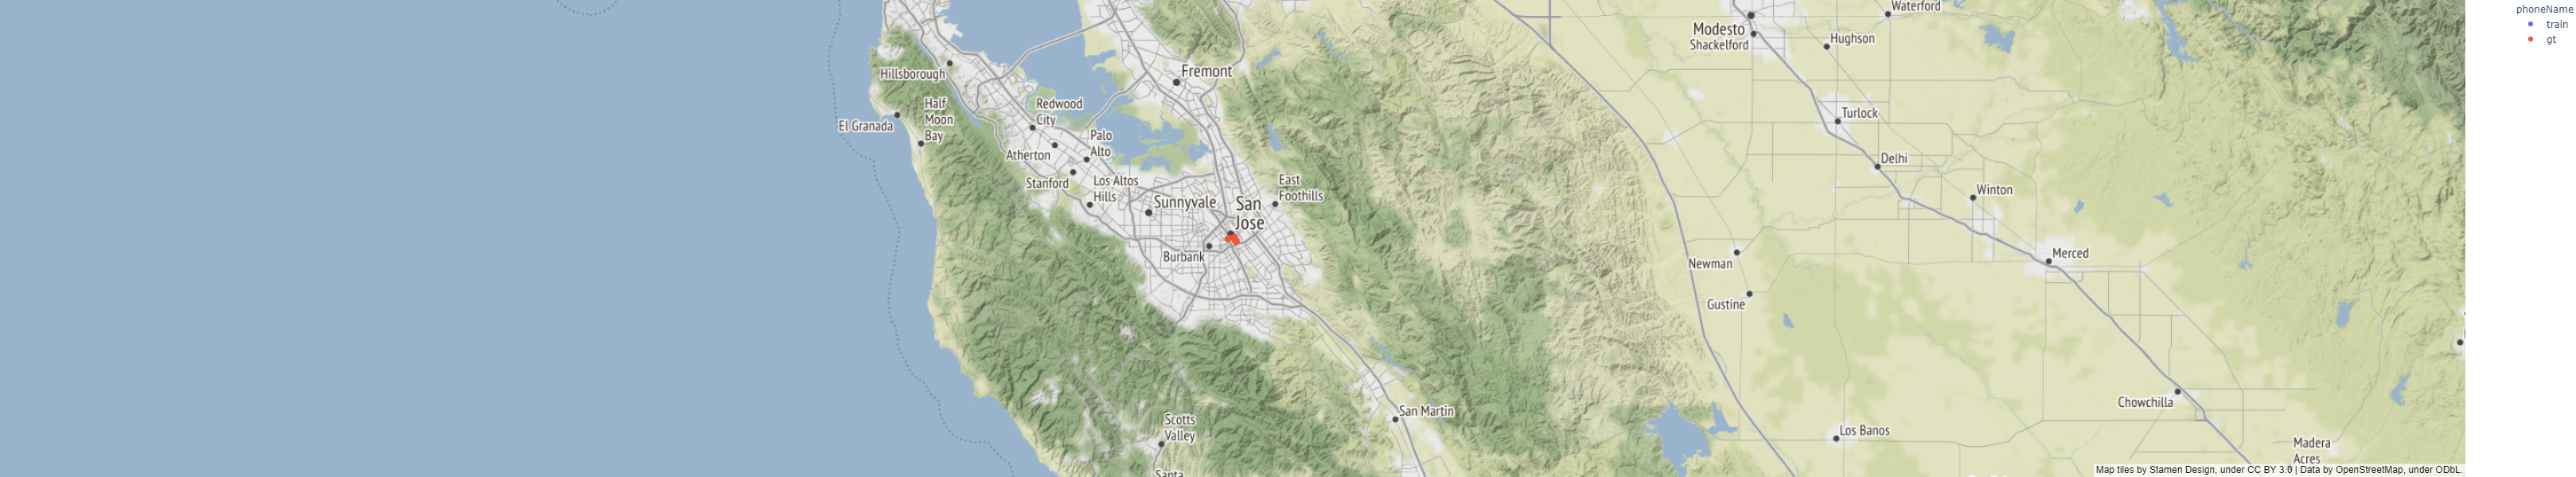

In [44]:
train['phone'] = train['collectionName'] + '_' + train['phoneName']
vis(train, '2021-04-22-US-SJC-1_Pixel4')

# position_shift

In [45]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)

def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt
msge = 'millisSinceGpsEpoch'

In [46]:
def position_shift(df,a):

    d = df.copy()
    d['heightAboveWgs84EllipsoidM'] = 63.5
    d['x'], d['y'], d['z'] = zip(*d.apply(lambda x: WGS84_to_ECEF(x.latDeg, x.lngDeg, x.heightAboveWgs84EllipsoidM), axis=1))

    #a = -0.2
    d.sort_values(['phone', msge], inplace=True)
    for fi in ['x','y','z']:
        d[[fi+'p']] = d[fi].shift().where(d['phone'].eq(d['phone'].shift()))
        d[[fi+'diff']] = d[fi]-d[fi+'p']
    #d[['yp']] = d['y'].shift().where(d['phone'].eq(d['phone'].shift()))
    d[['dist']] = np.sqrt(d['xdiff']**2 + d['ydiff']**2+ d['zdiff']**2)
    for fi in ['x','y','z']:
        d[[fi+'new']] = d[fi+'p'] + d[fi+'diff']*(1-a/d['dist'])
    lng, lat, alt = ECEF_to_WGS84(d['xnew'].values,d['ynew'].values,d['znew'].values)
    
    lng[np.isnan(lng)] = d.loc[np.isnan(lng),'lngDeg']
    lat[np.isnan(lat)] = d.loc[np.isnan(lat),'latDeg']
    d['latDeg'] = lat
    d['lngDeg'] = lng
    
    return d 

def objective(trial):
    a = trial.suggest_uniform('a', -1, 1)
    score = get_train_score(position_shift(train, a),gt)
    return score

In [47]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)
opt_a = study.best_params['a']
print(opt_a)

[I 2021-08-04 12:31:40,372] A new study created in memory with name: no-name-0d65b7c3-ac13-4798-95fd-696a80bff43d
[I 2021-08-04 12:31:41,045] Trial 0 finished with value: 5.712557102176358 and parameters: {'a': -0.8896333996273542}. Best is trial 0 with value: 5.712557102176358.
[I 2021-08-04 12:31:41,460] Trial 1 finished with value: 5.243204223477046 and parameters: {'a': 0.3204131258145113}. Best is trial 1 with value: 5.243204223477046.
[I 2021-08-04 12:31:41,874] Trial 2 finished with value: 5.559343098505903 and parameters: {'a': -0.6099136876104236}. Best is trial 1 with value: 5.243204223477046.
[I 2021-08-04 12:31:42,293] Trial 3 finished with value: 5.733375727713618 and parameters: {'a': -0.9307877377396974}. Best is trial 1 with value: 5.243204223477046.
[I 2021-08-04 12:31:42,717] Trial 4 finished with value: 5.2872511883851825 and parameters: {'a': 0.09538224241519311}. Best is trial 1 with value: 5.243204223477046.
[I 2021-08-04 12:31:43,244] Trial 5 finished with value:

0.5017526116352684


In [48]:
train = position_shift(train, opt_a)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0_pm_ps.csv', index=False)

In [49]:
res = train_result(train)
print(res.score)
display(res.err)

5.224040823104074


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               3.517118      9.722162      6.619640
2021-04-22-US-SJC-1_SamsungS20Ultra      3.459525      9.586943      6.523234
2021-04-28-US-SJC-1_Pixel4               2.293270      6.696005      4.494638
2021-04-28-US-SJC-1_SamsungS20Ultra      2.232614      6.849127      4.540871
2021-04-29-US-SJC-2_Pixel4               2.013680      7.184602      4.599141
2021-04-29-US-SJC-2_SamsungS20Ultra      2.039996      7.093446      4.566721

In [50]:
train_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv', usecols=['phone', 'millisSinceGpsEpoch', 'isSpeed0'])
train = train.merge(train_sp0_pred, on=['phone', 'millisSinceGpsEpoch'], how='left')
train = sp0_process(train)

In [51]:
res = train_result(train)
print(res.score)
display(res.err)

5.184444856519423


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               3.602684      9.945124      6.773904
2021-04-22-US-SJC-1_SamsungS20Ultra      3.490301      9.798014      6.644158
2021-04-28-US-SJC-1_Pixel4               2.291900      6.431748      4.361824
2021-04-28-US-SJC-1_SamsungS20Ultra      2.185666      6.572329      4.378997
2021-04-29-US-SJC-2_Pixel4               1.993403      6.933016      4.463210
2021-04-29-US-SJC-2_SamsungS20Ultra      2.078467      6.890685      4.484576

In [52]:
train.to_csv(OUTPUT + f'/{nb_name}_train.csv', index=False)

# sub作成

In [53]:
test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
test = test[test['collectionName'].isin(target)]

In [54]:
rb = pd.read_csv(f'{rb_dir}/result_test.csv')

rb = rb.rename(columns={'latDeg':'latDeg_rb', 'lngDeg':'lngDeg_rb'})

test = test.merge(rb[['millisSinceGpsEpoch', 'phone', 'latDeg_rb', 'lngDeg_rb']], on=['millisSinceGpsEpoch', 'phone'], how='left')

idx = test[~test['latDeg_rb'].isnull()].index
test.loc[idx, 'latDeg'] = test.loc[idx, 'latDeg_rb']
test.loc[idx, 'lngDeg'] = test.loc[idx, 'lngDeg_rb']

In [55]:
test_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/test_sp0_pred.csv', usecols=['phone', 'millisSinceGpsEpoch', 'isSpeed0'])
test = test.merge(test_sp0_pred, on=['phone', 'millisSinceGpsEpoch'], how='left')

dp_test = pd.read_csv('../output/prep/rel_pred_v002_seedavg/test_result.csv')
test = test.merge(dp_test[['millisSinceGpsEpoch', 'phone', 'lat_diff', 'lng_diff']], on=['millisSinceGpsEpoch', 'phone'], how='left')
test.loc[test['isSpeed0']==1, ['lat_diff', 'lng_diff']] = 0

In [56]:
test = add_distance_diff(test)
test.loc[((test['dist_prev'] > ro_th) & (test['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan

In [57]:
test = reject_outlier_by_base_trajectory(test)

2021-04-22-US-SJC-2_SamsungS20Ultra 305
2021-04-29-US-SJC-3_Pixel4 238
2021-04-29-US-SJC-3_SamsungS20Ultra 242


In [58]:
rog_df = test[test['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
test.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]

In [59]:
test = sp0_process(test)

In [60]:
test = interpolate_by_rel(test)

In [61]:
test = apply_kf_smoothing(test)

In [62]:
for phone in test['phone'].unique():
    idx = test[test['phone']==phone].index
    test.loc[idx, ['latDeg', 'lngDeg']] = cost_minimization(test.loc[idx], cost_min_beta_w)

In [63]:
test = calc_mean_pred(test, phones_mean_weights)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [64]:
test['phone'] = test['collectionName'] + '_' + test['phoneName']
test = position_shift(test, opt_a)

In [65]:
test_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/test_sp0_pred.csv', usecols=['phone', 'millisSinceGpsEpoch', 'isSpeed0'])
test = test.merge(test_sp0_pred, on=['phone', 'millisSinceGpsEpoch'], how='left')

In [66]:
test = sp0_process(test)

In [67]:
test = test[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']].copy()
test.to_csv(OUTPUT + f'/{nb_name}_test.csv', index=False)

In [68]:
test

phone  millisSinceGpsEpoch     latDeg  \
0     2021-04-22-US-SJC-2_SamsungS20Ultra        1303164074000  37.334551   
1     2021-04-22-US-SJC-2_SamsungS20Ultra        1303164075000  37.334551   
2     2021-04-22-US-SJC-2_SamsungS20Ultra        1303164076000  37.334551   
3     2021-04-22-US-SJC-2_SamsungS20Ultra        1303164077000  37.334551   
4     2021-04-22-US-SJC-2_SamsungS20Ultra        1303164078000  37.334551   
...                                   ...                  ...        ...   
6359  2021-04-29-US-SJC-3_SamsungS20Ultra        1303763185000  37.334594   
6360  2021-04-29-US-SJC-3_SamsungS20Ultra        1303763186000  37.334594   
6361  2021-04-29-US-SJC-3_SamsungS20Ultra        1303763187000  37.334594   
6362  2021-04-29-US-SJC-3_SamsungS20Ultra        1303763188000  37.334594   
6363  2021-04-29-US-SJC-3_SamsungS20Ultra        1303763189000  37.334594   

          lngDeg  
0    -121.899476  
1    -121.899476  
2    -121.899476  
3    -121.899476  
4    -121.899476  
...          ...  
6359 -121.899401  
6360 -121.899401  
6361 -121.899401  
6362 -121.899401  
6363 -121.899401  

[6364 rows x 4 columns]